In [54]:
import cudaq
from typing import List
import numpy as np 
from cudaq import spin
from scipy.optimize import minimize
from scipy.special import softmax
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc

cudaq.set_target("nvidia")

df_input = np.loadtxt("qc_pca_train_input_bace_12q2")
df_classes = np.loadtxt("qc_pca_train_classes_bace_12q2") - 1

df_test_input = np.loadtxt("qc_pca_test_input_bace_12q2")
df_test_classes = np.loadtxt("qc_pca_test_classes_bace_12q2") - 1

m = df_classes.size  #Number of data samples 
num_classes = int(max(df_classes)) + 1 #Number of classes
num_qubits = df_input.shape[1]
ansatz_layers = 1
maxiter = 1
num_theta = num_qubits * ansatz_layers
# theta_values = np.zeros(num_theta)
theta_values = np.array([-0.879411278071147, -2.163050261905418])
data_values  = df_input
class_values = df_classes

def gen_default_prob_class(num_qubits, num_classes):
    prob_class = np.zeros(2**num_qubits)
    for i in range(2**num_qubits):
        prob_class[i] = i % num_classes
    return prob_class

prob_class = gen_default_prob_class(num_qubits, num_classes)

In [58]:
@cudaq.kernel
def kernel(data: np.ndarray, theta: np.ndarray):
    
    q = cudaq.qvector(num_qubits)
    
    #Data encoding
    for i in range(num_qubits):
        ry(data[i], q[i])
    for i in range(num_qubits - 1):
        x.ctrl(q[i], q[i + 1])

    #Parameterised ansatz
    for i in range(ansatz_layers):
        for j in range(num_qubits):
            ry(theta[i * num_qubits + j], q[j])
        for j in range(num_qubits - 1):
            x.ctrl(q[j], q[j + 1])

def cost_function(theta_values):
    cost = 0.0
    for i in range(m):
        c = 0.0
        sv = np.array(cudaq.get_state(kernel, data_values[i], theta_values))
        prob = softmax(np.real(np.abs(sv) ** 2))
        for j in range(2**num_qubits):
            if prob_class[j] == class_values[i]:
                c += prob[j]
        cost += -np.log(c)
    cost = cost / m
    return cost

def find_prob(data, theta, classes):
    p = np.zeros(len(data))
    for i in range(len(data)):
        c = 0.0
        sv = np.array(cudaq.get_state(kernel, data[i], theta))
        prob = np.real(np.abs(sv) ** 2)
        for j in range(2**num_qubits):
            if prob_class[j] == classes[i]:
                c += prob[j]
        p[i] = c
    return p

In [59]:
loss = []
def callback(xk):
    loss.append(cost_function(xk))

result = minimize(cost_function, theta_values, method='COBYLA', callback=callback, options={'maxiter': maxiter})

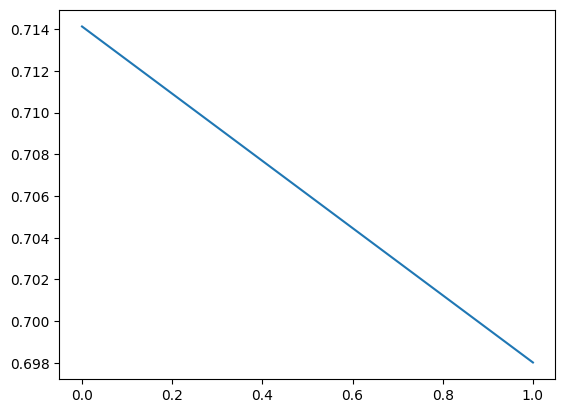

In [48]:
plt.plot(loss)

In [41]:
t_final = result.x
p_final = find_prob(data_values,t_final, class_values)
print(p_final)

[0.80605439 0.81513915 0.8150979  ... 0.56542869 0.69580693 0.7184903 ]


In [13]:
#Use only for binary classification
p_refined = np.zeros(m)
for i in range(m):
    if class_values[i] == 1:
        p_refined[i] = p_final[i]
    else:
        p_refined[i] = 1 - p_final[i]
roc_auc_score(class_values, p_refined)

0.5583544038555563

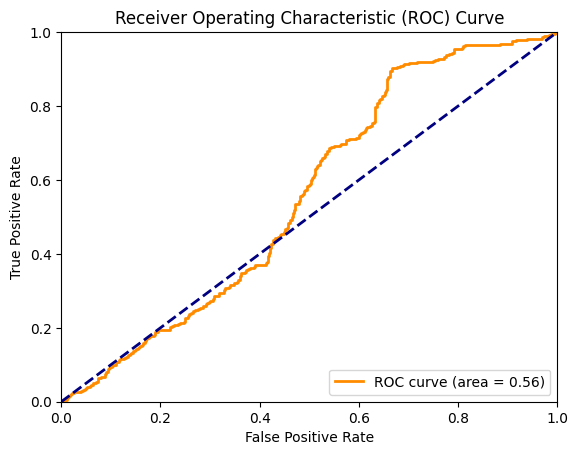

In [14]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(class_values, p_refined)

# Compute ROC AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [15]:
p_test_final = find_prob(df_test_input,t_final, df_test_classes)
#Use only for binary classification
p_test_refined = np.zeros(len(df_test_classes))
for i in range(len(df_test_classes)):
    if df_test_classes[i] == 1:
        p_test_refined[i] = p_final[i]
    else:
        p_test_refined[i] = 1 - p_test_final[i]
roc_auc_score(df_test_classes, p_test_refined)

0.49855072463768113